In [2]:
#Importing libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

np.random.seed(1234)
torch.manual_seed(1234)

#Reading data
learn_data = pd.read_csv("churn_modelling_audience.csv")
pd.options.display.max_columns = None
learn_data

In [3]:
#Reading data
learn_data = pd.read_csv("churn_modelling_audience.csv")
pd.options.display.max_columns = None
learn_data

,id,last_order_city_name,customer_type,last_order_device_channel,days_from_last_order,days_from_last_seen_at,lifetime_order_count,last30_days_order_amount,last30_days_order_count,last90_days_order_amount,last90_days_order_count,last365_days_order_amount,last365_days_order_count,churn
0,20002006408704,İstanbul,INDIVIDUAL,BROWSER,149,125,1,0,0,0,0,6375,1,True
1,20002005920692,Artvin,INDIVIDUAL,BROWSER,190,58,1,0,0,0,0,18435,1,True
2,20002001678732,İzmir,INDIVIDUAL,APP,89,88,1,0,0,6086,1,6086,1,False
3,20002002795327,Hatay,INDIVIDUAL,APP,162,58,1,0,0,0,0,10615,1,True
4,20002006408404,Bursa,INDIVIDUAL,BROWSER,149,89,1,0,0,0,0,15186,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,20002003647460,Ankara,INDIVIDUAL,BROWSER,358,264,3,0,0,0,0,26996,1,True
15996,20002009472837,Ankara,INDIVIDUAL,APP,46,46,1,0,0,6058,1,6058,1,False
15997,20002009066319,Ankara,INDIVIDUAL,APP,78,15,1,0,0,11934,1,11934,1,False
15998,20002003401739,Ankara,INDIVIDUAL,APP,341,170,5,0,0,0,0,37651,2,True


In [4]:
#Defining columns
numerical_columns = ['days_from_last_order', 'days_from_last_seen_at', 'lifetime_order_count',
                     'last30_days_order_amount', 'last30_days_order_count','last90_days_order_amount','last90_days_order_count','last365_days_order_amount','last365_days_order_count']

categorical_columns = ['last_order_city_name', 'customer_type', 'last_order_device_channel','churn']
outputs = ['churn']

In [5]:
churn_data = learn_data[learn_data['churn'] == 'true']
notchurn_data = learn_data[learn_data['churn'] == 'false']

In [6]:
#Processing columns

#Numerical
numerical_data = np.stack([learn_data[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)

#Categorical
for category in categorical_columns:
    learn_data[category] = learn_data[category].astype('category')
    
cn = learn_data['last_order_city_name'].cat.codes.values
ct = learn_data['customer_type'].cat.codes.values
dc = learn_data['last_order_device_channel'].cat.codes.values

categorical_data = np.stack([cn,ct,dc], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

#Outputs
learn_data[outputs] = learn_data[outputs].astype(int)

outputs = torch.tensor(learn_data[outputs].values).flatten()
outputs = outputs.long()

In [7]:
#Dividing the data
total_records = 16000
train_records = int(total_records * .6)
valid_records = int(total_records * .2)
test_records = int(total_records * .2)
numerical_train_data = numerical_data[:train_records]
numerical_valid_data = numerical_data[train_records:train_records+valid_records]
numerical_test_data = numerical_data[train_records+valid_records:total_records]
categorical_train_data = categorical_data[:train_records]
categorical_valid_data = categorical_data[train_records:train_records+valid_records]
categorical_test_data = categorical_data[train_records+valid_records:total_records]
train_outputs = outputs[:train_records]
valid_outputs = outputs[train_records:train_records+valid_records]
test_outputs = outputs[train_records+valid_records:total_records]

In [12]:
from torch.nn.parameter import Parameter
from torch.nn import init
import math

#Creating the Neural Network
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(10, 100)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm1d(100)
        self.weights1 = Parameter(torch.Tensor(1, 120))
        init.kaiming_uniform_(self.weights1, a=math.sqrt(5))
        
        self.weights2 = Parameter(torch.Tensor(1, 120))
        init.kaiming_uniform_(self.weights2, a=math.sqrt(5))
        
        self.bias1 = Parameter(torch.Tensor(1))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weights1)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias1, -bound, bound)
        
        self.bias2 = Parameter(torch.Tensor(1))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weights2)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias2, -bound, bound)
        
        self.layer1_1 = nn.Embedding(51, 5)
        self.bn1_1 = nn.BatchNorm1d(5)
        self.layer1_2 = nn.Embedding(2, 5)
        self.bn1_2 = nn.BatchNorm1d(5)
        self.layer1_3 = nn.Embedding(2, 5)
        self.bn1_3 = nn.BatchNorm1d(5)
        self.layer1_4 = nn.Embedding(3, 5)
        self.bn1_4 = nn.BatchNorm1d(5)
        
        self.layer2 = nn.Linear(120, 120)
        self.bn2 = nn.BatchNorm1d(120)
        
    def forward(self, x_numerical, x_categorical):
        x1 = self.layer1(x_numerical)
        x1 = self.relu(x1)
        x1 = self.bn1(x1)
        
        x1_embedding = self.layer1_1(x_categorical[:,0])
        x1_embedding = self.relu(x1_embedding)
        x1_embedding = self.bn1_1(x1_embedding)
        
        x2_embedding = self.layer1_2(x_categorical[:,1])
        x2_embedding = self.relu(x2_embedding)
        x2_embedding = self.bn1_2(x2_embedding)
        
        x3_embedding = self.layer1_3(x_categorical[:,2])
        x3_embedding = self.relu(x3_embedding)
        x3_embedding = self.bn1_3(x3_embedding)
        
        x_embedding = torch.cat([x1_embedding,x2_embedding,x3_embedding], 1)
                
        x1 = torch.cat([x1, x_embedding], 1)
        
        x2 = self.layer2(x1)        
        emb = self.relu(x2)
        x2 = self.bn2(emb)
        
        
        x2_weights1 = torch.mm(x2, self.weights1.t()) + self.bias1
        x2_weights2 = torch.mm(x2, self.weights2.t()) + self.bias2
        
        x3 = torch.cat([x2_weights1, x2_weights2], 1)
        
                
        return emb, self.weights1, self.weights2, x3

In [13]:
model = Model()

In [14]:
#===============================================================================================
# Defining churn:loyal weight ratio. churn_percentage=0.7 means churn:loyal weight ratio of 7:3.
# Setting churn_percentage=0.5 to get an unweighted model
#===============================================================================================
churn_percentage = 0.7

#Defining loss function
loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1-churn_percentage, churn_percentage]))
# loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#29 Juni 2020: menambahkan scheduler learning rate
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

In [15]:
#Training the data
epochs = 100 
batch_size = 10
mean_losses_train = []
mean_losses_valid = []
best_loss_valid = np.inf

for i in range(epochs):
    model.train()
    aggregated_losses_train = []
    aggregated_losses_valid = []
    i += 1
    idxs = np.random.permutation(train_records)
    for j in range((train_records//batch_size)+1):
        start_train = j*batch_size
        end_train = start_train+batch_size
        
        idxs_batch = idxs[start_train:end_train]
        
        train, weights1, weights2, train_embed = model(numerical_train_data[idxs_batch], categorical_train_data[idxs_batch]) # yg error 1
        train_loss = loss_function(train_embed, train_outputs[idxs_batch])
        aggregated_losses_train.append(train_loss)

        print(f'iteration: {j:3} loss: {train_loss.item():10.8f}')

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        mean_loss_train = torch.mean(torch.stack(aggregated_losses_train))
        
    print(f'epoch: {i:3} mean loss training: {mean_loss_train.item():10.8f}')
    mean_losses_train.append(mean_loss_train)
    
    model.eval()
    with torch.set_grad_enabled(False):
        for k in range((valid_records//batch_size)+1):
            start_valid = k*batch_size
            end_valid = start_valid+batch_size
            valid, weights1, weights2, valid_embed = model(numerical_valid_data[start_valid:end_valid], categorical_valid_data[start_valid:end_valid]) # kenapa disini harus ada 2 variabel prefix
            valid_loss = loss_function(valid_embed, valid_outputs[start_valid:end_valid])
            aggregated_losses_valid.append(valid_loss)
    mean_loss_valid = torch.mean(torch.stack(aggregated_losses_valid))
    print(f'epoch: {i:3} mean loss validation: {mean_loss_valid:.8f}')
    
    if mean_loss_valid.cpu().numpy()[()] < best_loss_valid:
        best_loss_valid = mean_loss_valid
        torch.save(model.state_dict(), "model_train_cre_{}.pth".format(churn_percentage))
        best_epoch = i        
    
    mean_losses_valid.append(mean_loss_valid)
    scheduler.step()

RuntimeError: size mismatch, m1: [10 x 9], m2: [10 x 100] at C:\Users\builder\AppData\Local\Temp\pip-req-build-e5c8dddg\aten\src\TH/generic/THTensorMath.cpp:136

In [37]:
model.load_state_dict(torch.load("model_train_cre_{}.pth".format(churn_percentage)))

FileNotFoundError: [Errno 2] No such file or directory: 'model_train_cre_0.7.pth'

In [12]:
#Creating predictions
with torch.no_grad():
    valid, valid_weights1, valid_weights2, valid_embed = model(numerical_valid_data, categorical_valid_data)
    valid_loss = loss_function(valid_embed, valid_outputs)
    total_valid_loss = valid_loss
print(f'Loss: {total_valid_loss:.8f}')

Loss: 0.35006952


In [13]:
# =============================================================================================
# [26 Mei 2020]: 
# hasil utama yang dilihat adalah F1 Score, karena metrik akurasi misleading digunakan untuk 
# data imbalance
# =============================================================================================

from sklearn.metrics import f1_score

valid_val = np.argmax(valid_embed, axis=1)
print(confusion_matrix(valid_outputs, valid_val))
print(classification_report(valid_outputs, valid_val))
print("Accuracy: ", accuracy_score(valid_outputs, valid_val))
print("F1 Score: ", f1_score(valid_outputs, valid_val, average='macro'))

[[534  30]
 [ 30  72]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       564
           1       0.71      0.71      0.71       102

    accuracy                           0.91       666
   macro avg       0.83      0.83      0.83       666
weighted avg       0.91      0.91      0.91       666

Accuracy:  0.9099099099099099
F1 Score:  0.8263454317897372


In [14]:
# function for smoothing the loss plot by using exponential moving average
# https://stackoverflow.com/questions/42281844/what-is-the-mathematics-behind-the-smoothing-parameter-in-tensorboards-scalar
def smooth(scalars, weight):
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

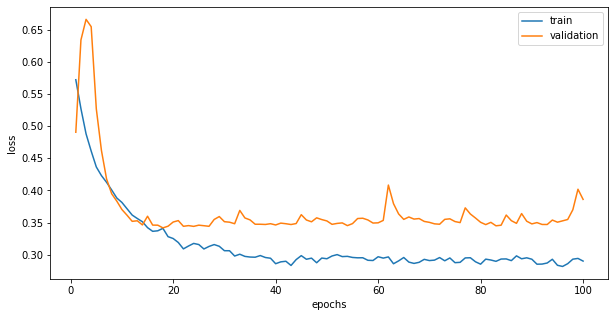

16


In [15]:
epochs_to_show = 100
smoothing = 0.5
plt.figure(figsize=(10,5))
plt.plot(range(1,epochs_to_show+1), smooth(mean_losses_train[0:epochs_to_show],smoothing), label = 'train')
plt.plot(range(1,epochs_to_show+1), smooth(mean_losses_valid[0:epochs_to_show],smoothing), label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')
# plt.ylim((0.0, 0.9))
# plt.title('loss graph')
plt.show()
print(best_epoch)